In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[..., np.newaxis]  # 4D arrays expected by our CNN
x_test = x_test[..., np.newaxis]  # 4D arrays expected by our CNN
# Normalize pixels between (0,1)
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.
K = len(set(y_train))
print("Number of train inputs: " + str(len(y_train)))
print("Number of test inputs: " + str(len(y_test)))
print("Number of classes: " + str(K))

Number of train inputs: 60000
Number of test inputs: 10000
Number of classes: 10


# High level CNN with Keras API

We aim to write a CNN in low-level Tensorflow. We first construct the target model with Keras functional API, to serve as a benchmark.

In [0]:
i = tf.keras.layers.Input(x_train.shape[1:])
x = i
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=K)(x)  # output are logits, not probabilities (no softmax)

model = tf.keras.Model(i, x)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),  # model output are logits!
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0   

In [0]:
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.1212 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.0425 - val_sparse_categorical_accuracy: 0.9856
Epoch 2/10
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0405 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0318 - val_sparse_categorical_accuracy: 0.9898
Epoch 3/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0273 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0247 - val_sparse_categorical_accuracy: 0.9913
Epoch 4/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0204 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0297 - val_sparse_categorical_accuracy: 0.9918
Epoch 5/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0178 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.0257 - val_sparse_categorical_accuracy: 0.9930
Epoch 6/10

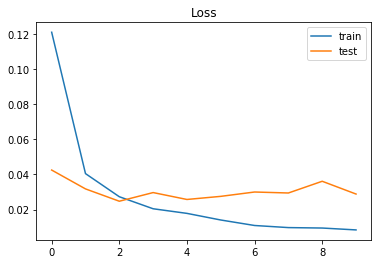

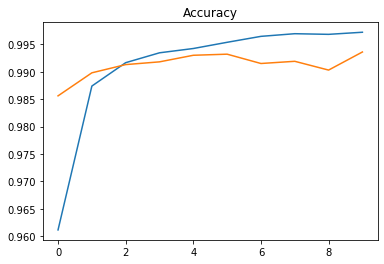

In [0]:
plt.plot(r.history['loss'], label='train')
plt.plot(r.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(r.history['sparse_categorical_accuracy'], label='train')
plt.plot(r.history['val_sparse_categorical_accuracy'], label='test')
plt.title('Accuracy')
plt.show()

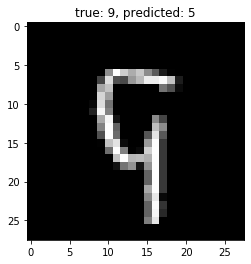

Continue? (Y/n):Y


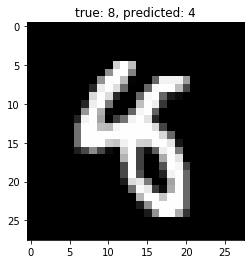

Continue? (Y/n):n


In [0]:
# Misclassified samples
p_test = tf.argmax(model(x_test), axis=1)
misclassified = np.where(p_test != y_test)[0]
for i in misclassified:
  plt.imshow(x_test[i,:,:,0], cmap='gray')
  plt.title(f'true: {y_test[i]}, predicted: {p_test[i]}')
  plt.plot()
  plt.show()
  answer = input('Continue? (Y/n):')
  if answer == 'n': break

# Low Level CNN

We subclass keras.layers.Layer and keras.Model, as described in:

https://www.tensorflow.org/guide/keras/custom_layers_and_models

These classes comes with convenient attributes, such has Layer.weights, Layer.trainable_weights, Model.layers, Model.weights, Model.trainable_weights. They all get populated automatically by the Layer's and Model's \_\_call\_\_ method.

The main Layer's methods to override are \_\_init\_\_, and build() and call(), both called by \_\_call\_\_. \_\_init\_\_ is meant to store the model's hyperparameters, but not to initialize weights. Weights should be initialised when the input is passed to the layer for the first time via \_\_call\_\_. If the layer has not been built,\_\_call\_\_ calls automatically the build() method, with argument input_shape. In the build() method, we can use the Layer.add_weight() method to create new weights. Finally, call() is meant to implement the layer'sforward pass. 

The main Model's methods to override are \_\_init\_\_ and call(). \_\_init\_\_ must contain all model's layers, assigned to attributes. call() implements the model's forward pass, using the layers defined in \_\_init\_\_. Note that the model populates attributes such as Model.layers and Model.weights by accumulating its layers's attributes, but only for the layers defined in \_\_init\_\_. Any layer defined in the call() method and not in \_\_init\_\_ is not seen by standard Keras functions. For example, it and its weights does not appear in the summary() method. Finally, the predict() method does not need to be overriden. predict() calls \_\_call\_\_ and then converts the output tensors into numpy arrays.

In [0]:
class ConvPoolBlock(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size, **kwargs):
    super().__init__(**kwargs)
    assert len(kernel_size) == 2
    self.filters = filters
    self.kernel_size = kernel_size
  
  def build(self, input_shape):
    assert len(input_shape) == 4
    self.w = self.add_weight(shape=(*self.kernel_size, input_shape[-1], self.filters),
                             initializer=tf.initializers.RandomNormal,
                             trainable=True)
    self.b = self.add_weight(shape=(self.filters, ),
                             initializer=tf.initializers.Zeros,
                             trainable=True)
  
  def call(self, inputs):
    x = tf.nn.conv2d(inputs, self.w, strides=[1,1,1,1], padding='SAME')
    x = tf.nn.bias_add(x, self.b)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool2d(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return x


class Dense(tf.keras.layers.Layer):
  def __init__(self, units, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.activation = activation

  def build(self, input_shape):
    assert len(input_shape) == 2
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer=tf.initializers.RandomNormal,
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer=tf.initializers.Zeros,
                             trainable=True)
  
  def call(self, inputs):
    x = tf.matmul(inputs, self.w) + self.b
    if self.activation: x = self.activation(x)
    return x


class Flatten(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
  
  def call(self, inputs):
    input_shape = inputs.shape
    batch_size = input_shape[0]
    flattened_dim = np.prod(input_shape[1:], dtype=int)
    return tf.reshape(inputs, shape=[batch_size, flattened_dim])


class CNN(tf.keras.Model):
  def __init__(self, n_classes, *kwargs):
    super().__init__(*kwargs)
    self.n_classes = n_classes
    self.convpool1 = ConvPoolBlock(filters=32, kernel_size=(3,3))
    self.convpool2 = ConvPoolBlock(filters=64, kernel_size=(3,3))
    self.convpool3 = ConvPoolBlock(filters=128, kernel_size=(3,3))
    self.flatten4 = tf.keras.layers.Flatten()  # our Flatten method triggers an exception in Model.fit()
    self.dense5 = Dense(units=128, activation=tf.nn.relu)
    self.dense6 = Dense(units=self.n_classes)  # output are logits
    # self.dense6 = Dense(units=self.n_classes, activation=tf.nn.softmax)  # output are probs

  def call(self, inputs):
    x = tf.dtypes.cast(inputs, tf.float32)
    x = self.convpool1(x)
    x = self.convpool2(x)
    x = self.convpool3(x)
    x = self.flatten4(x)
    x = self.dense5(x)
    x = self.dense6(x)
    return x


In [0]:
model = CNN(n_classes=K)
print(tf.argmax(model(x_train[0:1]), axis=1), end='\n\n') # We build the model by calling it
model.summary()

tf.Tensor([8], shape=(1,), dtype=int64)

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool_block_6 (ConvPoolB multiple                  320       
_________________________________________________________________
conv_pool_block_7 (ConvPoolB multiple                  18496     
_________________________________________________________________
conv_pool_block_8 (ConvPoolB multiple                  73856     
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  262272    
_________________________________________________________________
dense_9 (Dense)              multiple                  1290      
Total params: 356,234
Trainable params: 356,234
Non-trainable params: 0
______________

### Train using the inherited keras.Model's methods compile() and fit()

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),  # model output are logits!
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

r = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.1352 - sparse_categorical_accuracy: 0.9571 - val_loss: 0.0388 - val_sparse_categorical_accuracy: 0.9872
Epoch 2/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0424 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.0456 - val_sparse_categorical_accuracy: 0.9865
Epoch 3/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0294 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0237 - val_sparse_categorical_accuracy: 0.9920
Epoch 4/10
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0227 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.0305 - val_sparse_categorical_accuracy: 0.9905
Epoch 5/10
60000/60000 [==============================] - 7s 108us/sample - loss: 0.0178 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.0351 - val_sparse_categorical_accuracy: 0.9882
Epoch 6/10

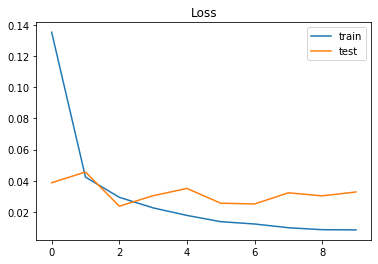

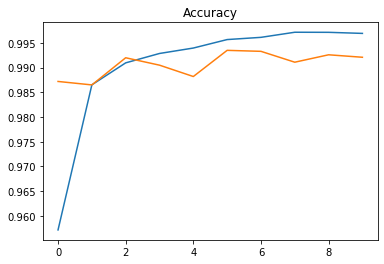

In [0]:
plt.plot(r.history['loss'], label='train')
plt.plot(r.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(r.history['sparse_categorical_accuracy'], label='train')
plt.plot(r.history['val_sparse_categorical_accuracy'], label='test')
plt.title('Accuracy')
plt.show()

## Low-level training loop with with GradientTape

In [0]:
from datetime import datetime
from sklearn.utils import shuffle

model = CNN(n_classes=K)

optimizer = tf.keras.optimizers.Adam()
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.metrics.SparseCategoricalAccuracy()

EPOCHS = 10
BATCH_SIZE = 32
n_train = len(y_train)
n_batches = (lambda n : n // BATCH_SIZE + n % BATCH_SIZE)(n_train)
train_losses = []
test_losses = []
train_metric = []
test_metric = []

for epoch in range(EPOCHS):
  print(f"Epoch {epoch + 1}", end='')
  t0 = datetime.now()
  x, y = shuffle(x_train, y_train)
  for i in range(n_batches):
    batch = range(i*BATCH_SIZE, min((i+1)*BATCH_SIZE, n_train))
    x_batch = x[batch]
    y_batch = y[batch]
    # Calculate gradients
    with tf.GradientTape() as tape:
      batch_loss = loss(y_batch, model(x_batch))
    grads = tape.gradient(batch_loss, model.trainable_weights)
    # Do one step of backpropagation via gradient descent
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # Compute epoch's end loss and metric
  p_train = model(x_train)
  p_test = model(x_test)
  train_loss = loss(y_train, p_train)
  test_loss = loss(y_test, p_test)
  train_accuracy = metric(y_train, p_train)
  test_accuracy = metric(y_test, p_test)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_metric.append(train_accuracy)
  test_metric.append(test_accuracy)

  print(f"[{datetime.now() - t0}]", end='')
  print(f", train loss: {train_loss:.2f}, test loss: {train_loss:.2f}", end='')
  print(f", train accuracy: {train_accuracy:.2f}, test accuracy: {test_accuracy:.2f}")

Epoch 1[0:00:19.927243], train loss: 0.06, test loss: 0.06, train accuracy: 0.98, test accuracy: 0.98
Epoch 2[0:00:19.858467], train loss: 0.05, test loss: 0.05, train accuracy: 0.98, test accuracy: 0.98
Epoch 3[0:00:19.611895], train loss: 0.02, test loss: 0.02, train accuracy: 0.99, test accuracy: 0.99
Epoch 4[0:00:19.961528], train loss: 0.02, test loss: 0.02, train accuracy: 0.99, test accuracy: 0.99
Epoch 5[0:00:19.592149], train loss: 0.02, test loss: 0.02, train accuracy: 0.99, test accuracy: 0.99
Epoch 6[0:00:20.383159], train loss: 0.01, test loss: 0.01, train accuracy: 0.99, test accuracy: 0.99
Epoch 7[0:00:19.535498], train loss: 0.03, test loss: 0.03, train accuracy: 0.99, test accuracy: 0.99
Epoch 8[0:00:19.574260], train loss: 0.01, test loss: 0.01, train accuracy: 0.99, test accuracy: 0.99
Epoch 9[0:00:19.776336], train loss: 0.01, test loss: 0.01, train accuracy: 0.99, test accuracy: 0.99
Epoch 10[0:00:19.508949], train loss: 0.01, test loss: 0.01, train accuracy: 0.99,

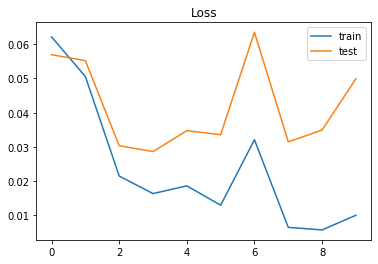

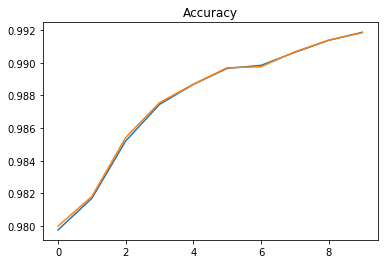

In [0]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.title('Loss')
plt.show()
plt.plot(train_metric, label='train')
plt.plot(test_metric, label='test')
plt.title('Accuracy')
plt.show()

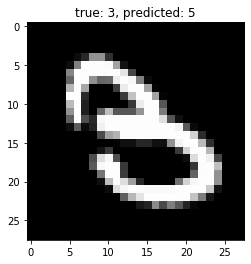

Continue? (Y/n):Y


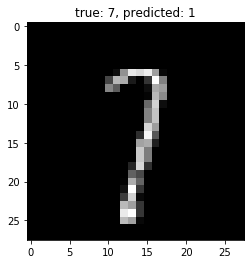

Continue? (Y/n):n


In [0]:
# Misclassified samples
p_test = tf.argmax(model(x_test), axis=1)  # or p_test = np.argmax(model.predict(x_test), axis=1)
misclassified = np.where(p_test != y_test)[0]
for i in misclassified:
  plt.imshow(x_test[i,:,:,0], cmap='gray')
  plt.title(f'true: {y_test[i]}, predicted: {p_test[i]}')
  plt.plot()
  plt.show()
  answer = input('Continue? (Y/n):')
  if answer == 'n': break